In [ ]:
# first mounting the drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

In [ ]:
directory = "/content/drive/MyDrive/Validation/input"

In [ ]:
    # List all files and directories in the folder
def count_files_in_folder(directory):
    all_items = os.listdir(directory)

    file_count = sum(1 for item in all_items if os.path.isfile(os.path.join(directory, item)))

    return file_count

print(f"Total files in '{directory}': {count_files_in_folder(directory)}")

Total files in '/content/drive/MyDrive/Validation/input': 1652


In [ ]:
## Already re-named the files dont accidentally re-run

import os

directory = "/content/drive/MyDrive/MRI/VALIDATION_DATA"

files_with_sizes = [(f, os.path.getsize(os.path.join(directory, f)))
                    for f in os.listdir(directory) if f.endswith(".h5")]

files_with_sizes.sort(key=lambda x: x[1], reverse=True)

    new_name = f"MRIV2_{index:03}.h5"

    old_path = os.path.join(directory, file)
    new_path = os.path.join(directory, new_name)

    os.rename(old_path, new_path)
    print(f"Renamed: {file} -> {new_name} (Size: {size} bytes)")

print("Renaming complete!")

Renamed: MRIV_001.h5 -> MRIV2_001.h5 (Size: 788021272 bytes)
Renamed: MRIV_002.h5 -> MRIV2_002.h5 (Size: 788021272 bytes)
Renamed: MRIV_003.h5 -> MRIV2_003.h5 (Size: 788021272 bytes)
Renamed: MRIV_004.h5 -> MRIV2_004.h5 (Size: 788021272 bytes)
Renamed: MRIV_006.h5 -> MRIV2_005.h5 (Size: 788021264 bytes)
Renamed: MRIV_007.h5 -> MRIV2_006.h5 (Size: 788021248 bytes)
Renamed: MRIV_008.h5 -> MRIV2_007.h5 (Size: 788021248 bytes)
Renamed: MRIV_012.h5 -> MRIV2_008.h5 (Size: 778585648 bytes)
Renamed: MRIV_010.h5 -> MRIV2_009.h5 (Size: 778585648 bytes)
Renamed: MRIV_011.h5 -> MRIV2_010.h5 (Size: 778585648 bytes)
Renamed: MRIV_009.h5 -> MRIV2_011.h5 (Size: 778585648 bytes)
Renamed: MRIV_013.h5 -> MRIV2_012.h5 (Size: 681264712 bytes)
Renamed: MRIV_014.h5 -> MRIV2_013.h5 (Size: 632307272 bytes)
Renamed: MRIV_015.h5 -> MRIV2_014.h5 (Size: 632307248 bytes)
Renamed: MRIV_016.h5 -> MRIV2_015.h5 (Size: 632307248 bytes)
Renamed: MRIV_017.h5 -> MRIV2_016.h5 (Size: 632307248 bytes)
Renamed: MRIV_018.h5 -> 

In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/101.4 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.0 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=df408dcc0a7c9bfc8bc80a8263f62a44c4672d5ee9e675a2dc2c729379f0effd
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


In [ ]:
import os
import numpy as np
import h5py
import torch
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from fastmri import ifft2c

In [ ]:
# Constants
BATCH_SIZE = 1  # Reduced batch size to prevent RAM overload
TARGET_SIZE = (320, 640)  # Final image size
NUM_SPOKES = 90  # Radial sampling spokes

def kspace_to_image(kspace_data):
    """Convert k-space data to images using inverse FFT and GPU."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")
    image_tensor = ifft2c(kspace_tensor)
    magnitude_images = torch.abs(image_tensor)
    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)
    magnitude_images *= 255.0
    return magnitude_images.byte().cpu().numpy()

def combine_images(images):
    """Combine coil images using Root Sum of Squares (RSS)."""
    combined_image = np.sqrt(np.sum(images.astype(np.float32) ** 2, axis=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.astype(np.uint8)

def crop_or_resize_image(image, target_size):
    """Crop or resize an image to the target size."""
    if image.ndim == 3 and image.shape[-1] == 2:
        image = np.abs(image[..., 0] + 1j * image[..., 1])
    current_height, current_width = image.shape
    target_height, target_width = target_size
    crop_top = max((current_height - target_height) // 2, 0)
    crop_bottom = crop_top + target_height
    crop_left = max((current_width - target_width) // 2, 0)
    crop_right = crop_left + target_width
    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]
    resized_image = Image.fromarray(cropped_image).resize(target_size, Image.Resampling.LANCZOS)
    return np.array(resized_image, dtype=np.uint8)

def radial_sampling_mask(shape, num_spokes):
    """Generate a radial sampling mask."""
    mask = np.zeros(shape, dtype=bool)
    center = (shape[0] // 2, shape[1] // 2)
    for angle in np.linspace(0, np.pi, num_spokes, endpoint=False):
        for r in range(min(shape) // 2):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            if 0 <= x < shape[0] and 0 <= y < shape[1]:
                mask[x, y] = True
    return mask

def process_file(file_path, output_folder, target_size, num_spokes):
    """Process a single .h5 file and save images."""
    ground_truth_folder = os.path.join(output_folder, "ground_truth")
    input_folder = os.path.join(output_folder, "input")
    os.makedirs(ground_truth_folder, exist_ok=True)
    os.makedirs(input_folder, exist_ok=True)

    with h5py.File(file_path, "r") as hf:
        kspace = hf["kspace"][:]  # Shape: (num_slices, num_coils, height, width)
        num_slices = kspace.shape[0]
        file_id = os.path.basename(file_path).replace(".h5", "")

        for slice_idx in range(num_slices):
            slice_kspace = kspace[slice_idx]

            ground_truth_images = kspace_to_image(slice_kspace)
            ground_truth_combined = combine_images(ground_truth_images)
            ground_truth_resized = crop_or_resize_image(ground_truth_combined, target_size)
            ground_truth_path = os.path.join(ground_truth_folder, f"{file_id}_slice_{slice_idx:03d}.png")
            Image.fromarray(ground_truth_resized).convert("L").save(ground_truth_path)

            mask = radial_sampling_mask(slice_kspace.shape[-2:], num_spokes)
            undersampled_kspace = slice_kspace * mask[None, :, :]
            masked_images = kspace_to_image(undersampled_kspace)
            masked_combined = combine_images(masked_images)
            masked_resized = crop_or_resize_image(masked_combined, target_size)
            input_path = os.path.join(input_folder, f"{file_id}_slice_{slice_idx:03d}.png")
            Image.fromarray(masked_resized).convert("L").save(input_path)



In [ ]:
# Function to process files in batches
def process_all_files_in_batches(input_folder, output_folder, batch_size, target_size, num_spokes):
    """Process all .h5 files in batches."""
    file_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".h5")]
    for i in tqdm(range(0, len(file_paths), batch_size), desc="Processing Batches"):
        batch = file_paths[i:i + batch_size]
        for file_path in batch:
            process_file(file_path, output_folder, target_size, num_spokes)

input_folder = "/content/drive/MyDrive/MRI/TRAINING_DATA"
output_folder = "/content/drive/MyDrive/Training"

process_all_files_in_batches(input_folder, output_folder, BATCH_SIZE, TARGET_SIZE, NUM_SPOKES)

Processing Batches:  25%|██▌       | 48/190 [09:33<24:47, 10.47s/it]<ipython-input-4-c00a27e6387a>:23: RuntimeWarning: invalid value encountered in divide
  combined_image /= combined_image.max()
<ipython-input-4-c00a27e6387a>:25: RuntimeWarning: invalid value encountered in cast
  return combined_image.astype(np.uint8)
Processing Batches: 100%|██████████| 190/190 [30:57<00:00,  9.78s/it]


In [ ]:
from google.colab import drive
drive.flush_and_unmount()  # Unmounts
drive.mount('/content/drive')  # Remounts


Mounted at /content/drive


In [ ]:
                # Check if the file is readable
import os
import h5py

input_folder = "/content/drive/MyDrive/MRI/TRAINING_DATA"
corrupted_files = []

for file_name in os.listdir(input_folder):
    if file_name.endswith(".h5"):
        file_path = os.path.join(input_folder, file_name)
        try:
            with h5py.File(file_path, "r") as hf:
                hf.keys()
        except OSError:
            corrupted_files.append(file_name)

if corrupted_files:
    print("Corrupted files:", corrupted_files)
else:
    print("No corrupted files found.")

Corrupted files: ['MRIT_073.h5', 'MRIT_074.h5', 'MRIT_079.h5', 'MRIT_080.h5', 'MRIT_081.h5', 'MRIT_082.h5', 'MRIT_083.h5', 'MRIT_084.h5', 'MRIT_085.h5', 'MRIT_086.h5', 'MRIT_087.h5', 'MRIT_092.h5', 'MRIT_093.h5', 'MRIT_095.h5', 'MRIT_096.h5', 'MRIT_097.h5', 'MRIT_098.h5', 'MRIT_112.h5', 'MRIT_113.h5', 'MRIT_114.h5', 'MRIT_115.h5', 'MRIT_116.h5', 'MRIT_117.h5', 'MRIT_118.h5', 'MRIT_119.h5', 'MRIT_120.h5', 'MRIT_121.h5', 'MRIT_122.h5', 'MRIT_123.h5', 'MRIT_124.h5', 'MRIT_125.h5', 'MRIT_131.h5', 'MRIT_132.h5', 'MRIT_133.h5', 'MRIT_134.h5', 'MRIT_135.h5', 'MRIT_152.h5', 'MRIT_153.h5', 'MRIT_154.h5', 'MRIT_155.h5', 'MRIT_156.h5', 'MRIT_157.h5', 'MRIT_158.h5', 'MRIT_159.h5', 'MRIT_160.h5', 'MRIT_161.h5', 'MRIT_162.h5', 'MRIT_163.h5', 'MRIT_164.h5', 'MRIT_165.h5', 'MRIT_166.h5', 'MRIT_167.h5', 'MRIT_168.h5', 'MRIT_169.h5', 'MRIT_170.h5', 'MRIT_171.h5', 'MRIT_172.h5', 'MRIT_173.h5', 'MRIT_176.h5', 'MRIT_177.h5', 'MRIT_178.h5', 'MRIT_179.h5', 'MRIT_180.h5', 'MRIT_188.h5', 'MRIT_189.h5', 'MRIT_1

In [ ]:
# List of corrupted files
corrupted_files = ['MRIT_079.h5', 'MRIT_092.h5', 'MRIT_093.h5', 'MRIT_170.h5', 'MRIT_171.h5', 'MRIT_081.h5', 'MRIT_082.h5', 'MRIT_177.h5', 'MRIT_178.h5', 'MRIT_075.h5', 'MRIT_076.h5', 'MRIT_172.h5', 'MRIT_173.h5', 'MRIT_073.h5', 'MRIT_074.h5', 'MRIT_179.h5', 'MRIT_180.h5', 'MRIT_083.h5', 'MRIT_084.h5', 'MRIT_085.h5', 'MRIT_086.h5', 'MRIT_331.h5', 'MRIT_057.h5', 'MRIT_303.h5', 'MRIT_201.h5', 'MRIT_188.h5', 'MRIT_152.h5', 'MRIT_153.h5', 'MRIT_112.h5', 'MRIT_189.h5', 'MRIT_249.h5', 'MRIT_154.h5', 'MRIT_113.h5', 'MRIT_332.h5', 'MRIT_307.h5', 'MRIT_415.h5', 'MRIT_333.h5', 'MRIT_155.h5', 'MRIT_267.h5', 'MRIT_190.h5', 'MRIT_295.h5', 'MRIT_156.h5', 'MRIT_157.h5', 'MRIT_058.h5', 'MRIT_371.h5', 'MRIT_059.h5', 'MRIT_114.h5', 'MRIT_282.h5', 'MRIT_202.h5', 'MRIT_158.h5', 'MRIT_115.h5', 'MRIT_203.h5', 'MRIT_372.h5', 'MRIT_028.h5', 'MRIT_416.h5', 'MRIT_417.h5', 'MRIT_001.h5', 'MRIT_011.h5', 'MRIT_060.h5', 'MRIT_159.h5', 'MRIT_448.h5', 'MRIT_418.h5', 'MRIT_131.h5', 'MRIT_012.h5', 'MRIT_013.h5', 'MRIT_204.h5', 'MRIT_263.h5', 'MRIT_373.h5', 'MRIT_205.h5', 'MRIT_419.h5', 'MRIT_213.h5', 'MRIT_014.h5', 'MRIT_374.h5', 'MRIT_015.h5', 'MRIT_420.h5', 'MRIT_087.h5', 'MRIT_116.h5', 'MRIT_240.h5', 'MRIT_264.h5', 'MRIT_421.h5', 'MRIT_223.h5', 'MRIT_117.h5', 'MRIT_191.h5', 'MRIT_118.h5', 'MRIT_192.h5', 'MRIT_422.h5', 'MRIT_160.h5', 'MRIT_334.h5', 'MRIT_296.h5', 'MRIT_132.h5', 'MRIT_423.h5', 'MRIT_061.h5', 'MRIT_062.h5', 'MRIT_424.h5', 'MRIT_224.h5', 'MRIT_096.h5', 'MRIT_225.h5', 'MRIT_226.h5', 'MRIT_375.h5', 'MRIT_272.h5', 'MRIT_297.h5', 'MRIT_133.h5', 'MRIT_161.h5', 'MRIT_063.h5', 'MRIT_335.h5', 'MRIT_162.h5', 'MRIT_064.h5', 'MRIT_163.h5', 'MRIT_065.h5', 'MRIT_119.h5', 'MRIT_376.h5', 'MRIT_336.h5', 'MRIT_273.h5', 'MRIT_016.h5', 'MRIT_164.h5', 'MRIT_120.h5', 'MRIT_227.h5', 'MRIT_165.h5', 'MRIT_298.h5', 'MRIT_337.h5', 'MRIT_425.h5', 'MRIT_377.h5', 'MRIT_338.h5', 'MRIT_299.h5', 'MRIT_378.h5', 'MRIT_426.h5', 'MRIT_166.h5', 'MRIT_241.h5', 'MRIT_167.h5', 'MRIT_427.h5', 'MRIT_066.h5', 'MRIT_228.h5', 'MRIT_168.h5', 'MRIT_339.h5', 'MRIT_229.h5', 'MRIT_265.h5', 'MRIT_274.h5', 'MRIT_230.h5', 'MRIT_283.h5', 'MRIT_017.h5', 'MRIT_379.h5', 'MRIT_214.h5', 'MRIT_310.h5', 'MRIT_428.h5', 'MRIT_380.h5', 'MRIT_429.h5', 'MRIT_169.h5', 'MRIT_242.h5', 'MRIT_067.h5', 'MRIT_121.h5', 'MRIT_018.h5', 'MRIT_068.h5', 'MRIT_381.h5', 'MRIT_430.h5', 'MRIT_431.h5', 'MRIT_019.h5', 'MRIT_432.h5', 'MRIT_020.h5', 'MRIT_069.h5', 'MRIT_070.h5', 'MRIT_231.h5', 'MRIT_232.h5', 'MRIT_206.h5', 'MRIT_029.h5', 'MRIT_433.h5', 'MRIT_193.h5', 'MRIT_434.h5', 'MRIT_097.h5', 'MRIT_300.h5', 'MRIT_340.h5', 'MRIT_382.h5', 'MRIT_254.h5', 'MRIT_311.h5', 'MRIT_435.h5', 'MRIT_134.h5', 'MRIT_284.h5', 'MRIT_341.h5', 'MRIT_436.h5', 'MRIT_342.h5', 'MRIT_233.h5', 'MRIT_308.h5', 'MRIT_301.h5', 'MRIT_437.h5', 'MRIT_207.h5', 'MRIT_312.h5', 'MRIT_122.h5', 'MRIT_285.h5', 'MRIT_438.h5', 'MRIT_439.h5', 'MRIT_286.h5', 'MRIT_243.h5', 'MRIT_234.h5', 'MRIT_215.h5', 'MRIT_383.h5', 'MRIT_098.h5', 'MRIT_384.h5', 'MRIT_123.h5', 'MRIT_385.h5', 'MRIT_021.h5', 'MRIT_208.h5', 'MRIT_306.h5', 'MRIT_022.h5', 'MRIT_386.h5', 'MRIT_255.h5', 'MRIT_343.h5', 'MRIT_387.h5', 'MRIT_209.h5', 'MRIT_302.h5', 'MRIT_235.h5', 'MRIT_210.h5', 'MRIT_216.h5', 'MRIT_440.h5', 'MRIT_287.h5', 'MRIT_388.h5', 'MRIT_441.h5', 'MRIT_389.h5', 'MRIT_313.h5', 'MRIT_449.h5', 'MRIT_442.h5', 'MRIT_095.h5', 'MRIT_443.h5', 'MRIT_124.h5', 'MRIT_444.h5', 'MRIT_023.h5', 'MRIT_275.h5', 'MRIT_135.h5', 'MRIT_445.h5', 'MRIT_320.h5', 'MRIT_390.h5', 'MRIT_030.h5', 'MRIT_391.h5', 'MRIT_125.h5']

num_corrupted_files = len(corrupted_files)
print(f"Number of corrupted files: {num_corrupted_files}")


Number of corrupted files: 232


In [ ]:
import os

input_folder = "/content/drive/MyDrive/MRI/TRAINING_DATA"

all_files = [f for f in os.listdir(input_folder) if f.endswith(".h5")]
num_all_files = len(all_files)

num_uncorrupted_files = num_all_files - num_corrupted_files
print(f"Total files: {num_all_files}")
print(f"Uncorrupted files: {num_uncorrupted_files}")


Total files: 234
Uncorrupted files: 2


In [ ]:
# Directory containing the converted images
import os
import re

converted_images_path = "/content/drive/MyDrive/Training/ground_truth"

pattern = r"MRIT_(\d+)_slice_\d+.png"

converted_file_numbers = set()
number = 0
for file_name in os.listdir(converted_images_path):
    match = re.match(pattern, file_name)
    if match:
        converted_file_numbers.add(int(match.group(1)))
        number+=1  # Extract the file number

converted_file_numbers = sorted(converted_file_numbers)

print(converted_file_numbers)
print(number)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 77, 78, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 

In [ ]:
#print(f"New files added: {new}")
prev = [2, 3, 4, 5, 6, 7, 8, 9, 10, 24, 25, 26, 27, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 71, 72, 77, 78, 88, 89, 90, 91, 94, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 126, 127, 128, 129, 130, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 174, 175, 181, 182, 183, 184, 185, 186, 187, 194, 195, 196, 197, 198, 199, 200, 211, 212, 217, 218, 219, 220, 221, 222, 236, 237, 238, 239, 244, 245, 246, 247, 248, 250, 251, 252, 253, 256, 257, 258, 259, 260, 261, 262, 266, 268, 269, 270, 271, 276, 277, 278, 279, 280, 281, 288, 289, 290, 291, 292, 293, 294, 304, 305, 309, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 446, 447, 450]

now = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 77, 78, 88, 89, 90, 91, 94, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 126, 127, 128, 129, 130, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 174, 175, 181, 182, 183, 184, 185, 186, 187, 194, 195, 196, 197, 198, 199, 200, 211, 212, 217, 218, 219, 220, 221, 222, 236, 237, 238, 239, 244, 245, 246, 247, 248, 250, 251, 252, 253, 256, 257, 258, 259, 260, 261, 262, 266, 268, 269, 270, 271, 276, 277, 278, 279, 280, 281, 288, 289, 290, 291, 292, 293, 294, 304, 305, 309, 314, 315, 316, 317, 318, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 446, 447, 450]

new = list(set(now) - set(prev))
new.sort()

len(new)

31

In [ ]:
# Define paths
import os
import shutil

source_folder = "/content/drive/MyDrive/MRI/VALIDATION_DATA"
destination_folder = "/content/drive/MyDrive/MRI/VALIDATION_DATA_converted"

os.makedirs(destination_folder, exist_ok=True)

converted_numbers = {5, 7, 8, 9, 10, 11, 21, 22, 28, 29, 30, 31, 32, 33, 38, 39, 44, 47, 48, 49, 52, 60, 61, 62, 63, 64, 66, 69, 72, 73, 74, 75, 76, 78, 79, 80, 84, 85, 86, 87, 88, 96, 97, 98, 99, 100, 101, 102}
for file_name in os.listdir(source_folder):
    if file_name.startswith("MRIV_") and file_name.endswith(".h5"):
        try:
            file_number = int(file_name.split("_")[1].split(".")[0])
            if file_number in converted_numbers:
                source_path = os.path.join(source_folder, file_name)
                destination_path = os.path.join(destination_folder, file_name)
                shutil.move(source_path, destination_path)
                print(f"Moved: {file_name}")
        except (IndexError, ValueError):
            print(f"Skipping file with unexpected format: {file_name}")

print("File transfer complete!")

Moved: MRIV_021.h5
Moved: MRIV_066.h5
Moved: MRIV_009.h5
Moved: MRIV_076.h5
Moved: MRIV_096.h5
Moved: MRIV_078.h5
Moved: MRIV_084.h5
Moved: MRIV_097.h5
Moved: MRIV_047.h5
Moved: MRIV_079.h5
Moved: MRIV_028.h5
Moved: MRIV_073.h5
Moved: MRIV_022.h5
Moved: MRIV_060.h5
Moved: MRIV_061.h5
Moved: MRIV_098.h5
Moved: MRIV_029.h5
Moved: MRIV_072.h5
Moved: MRIV_080.h5
Moved: MRIV_099.h5
Moved: MRIV_010.h5
Moved: MRIV_030.h5
Moved: MRIV_007.h5
Moved: MRIV_100.h5
Moved: MRIV_085.h5
Moved: MRIV_063.h5
Moved: MRIV_069.h5
Moved: MRIV_086.h5
Moved: MRIV_031.h5
Moved: MRIV_074.h5
Moved: MRIV_052.h5
Moved: MRIV_048.h5
Moved: MRIV_011.h5
Moved: MRIV_032.h5
Moved: MRIV_044.h5
Moved: MRIV_064.h5
Moved: MRIV_033.h5
Moved: MRIV_101.h5
Moved: MRIV_062.h5
Moved: MRIV_049.h5
Moved: MRIV_102.h5
Moved: MRIV_087.h5
Moved: MRIV_075.h5
Moved: MRIV_088.h5
Moved: MRIV_005.h5
Moved: MRIV_008.h5
Moved: MRIV_038.h5
Moved: MRIV_039.h5
File transfer complete!


In [ ]:
# Define constants
BATCH_SIZE = 10  # Number of .h5 files to process at a time
target_size = (320, 640)  # Target size for images
num_spokes = 90  # Number of spokes for radial sampling

def kspace_to_image(kspace_data):
    """Convert k-space data to images using inverse FFT."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")
    image_tensor = ifft2c(kspace_tensor)
    magnitude_images = torch.abs(image_tensor)
    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)
    magnitude_images *= 255.0
    return magnitude_images.byte().cpu().numpy()

def combine_images(images):
    """Combine images from multiple coils using RSS."""
    combined_image = np.sqrt(np.sum(images.astype(np.float32) ** 2, axis=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.astype(np.uint8)

def radial_sampling_mask(shape, num_spokes):
    """Generate a radial sampling mask."""
    mask = np.zeros(shape, dtype=bool)
    center = (shape[0] // 2, shape[1] // 2)
    for angle in np.linspace(0, np.pi, num_spokes, endpoint=False):
        for r in range(min(shape) // 2):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            if 0 <= x < shape[0] and 0 <= y < shape[1]:
                mask[x, y] = True
    return mask

def apply_radial_sampling(kspace, mask):
    """Apply radial sampling mask to k-space."""
    return kspace * mask[None, :, :]

def crop_or_resize_image(image, target_size=(320, 640)):
    """Crop or resize an image to the target size."""
    if image.ndim == 3 and image.shape[-1] == 2:
        image = np.abs(image[..., 0] + 1j * image[..., 1])

    current_height, current_width = image.shape
    target_height, target_width = target_size

    crop_top = max((current_height - target_height) // 2, 0)
    crop_bottom = crop_top + target_height
    crop_left = max((current_width - target_width) // 2, 0)
    crop_right = crop_left + target_width

    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]

    resized_image = Image.fromarray(cropped_image).resize(target_size, Image.Resampling.LANCZOS)
    return np.array(resized_image, dtype=np.uint8)

def process_batch(file_paths, output_folder, target_size=(320, 640), num_spokes=90):
    """Process a batch of .h5 files."""
    ground_truth_folder = os.path.join(output_folder, "ground_truth")
    input_folder = os.path.join(output_folder, "input")
    os.makedirs(ground_truth_folder, exist_ok=True)
    os.makedirs(input_folder, exist_ok=True)

    for file_path in file_paths:
        with h5py.File(file_path, "r") as hf:
            kspace = hf["kspace"][:]  # Shape: (num_slices, num_coils, height, width)
            num_slices = kspace.shape[0]

            file_id = os.path.basename(file_path).replace(".h5", "")
            for slice_idx in range(num_slices):
                slice_kspace = kspace[slice_idx]  # Shape: (num_coils, height, width)

                ground_truth_images = kspace_to_image(slice_kspace)
                ground_truth_combined = combine_images(ground_truth_images)
                ground_truth_resized = crop_or_resize_image(ground_truth_combined, target_size)

                
                ground_truth_path = os.path.join(ground_truth_folder, f"{file_id}_slice_{slice_idx:03d}.png")
                Image.fromarray(ground_truth_resized).convert("L").save(ground_truth_path)

               
                mask = radial_sampling_mask(slice_kspace.shape[-2:], num_spokes)
                undersampled_kspace = apply_radial_sampling(slice_kspace, mask)
                masked_images = kspace_to_image(undersampled_kspace)
                masked_combined = combine_images(masked_images)
                masked_resized = crop_or_resize_image(masked_combined, target_size)

                
                input_path = os.path.join(input_folder, f"{file_id}_slice_{slice_idx:03d}.png")
                Image.fromarray(masked_resized).convert("L").save(input_path)


In [ ]:
    # Print the sizes
import os
from PIL import Image

def check_image_sizes(directory):

    image_files = [f for f in os.listdir(directory) if f.endswith((".png", ".jpg", ".jpeg"))]
    sizes = []

    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        with Image.open(image_path) as img:
            width, height = img.size
            sizes.append((image_file, width, height))

    for image_file, width, height in sizes:
        print(f"Image: {image_file}, Width: {width}, Height: {height}")


combined_images_folder = "/content/drive/MyDrive/MRI/final_test_run/ground_truth"
check_image_sizes(combined_images_folder)


Image: file_brain_AXT2_210_6001948_slice_000.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_001.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_002.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_003.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_004.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_005.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_006.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_007.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_008.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_009.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_010.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_011.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_slice_012.png, Width: 320, Height: 640
Image: file_brain_AXT2_210_6001948_sli

In [ ]:
## Everything below here was just experimentation, above is the final processing pipeline of the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/101.4 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.8 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=86d4b0e703d7a49246226f65733ee4afd6220424b71ea81b2af6bc7e88507334
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


In [ ]:
    # Convert to PyTorch tensor
from fastmri import tensor_to_complex_np, ifft2c
import torch

def kspace_to_image(kspace):
    """
    Convert k-space data to an image using fastmri utilities.
    Args:
        kspace (numpy.ndarray): K-space data for a single slice and coil.

    Returns:
        numpy.ndarray: Reconstructed image.
    """
    kspace_tensor = torch.tensor(kspace).unsqueeze(0)  # Add batch dimension
    image_tensor = ifft2c(kspace_tensor)
    image = tensor_to_complex_np(image_tensor.squeeze(0))  # Remove batch dimension
    image = np.abs(image)
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255.0
    return image.astype(np.uint8)

In [ ]:
# Function to convert k-space to image using fastMRI
def kspace_to_image_fastmri(kspace_data):
    """Converts k-space data to an image using fastMRI."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32)

    image_tensor = ifft2c(kspace_tensor)
    image_np = tensor_to_complex_np(image_tensor)

    combined_image = np.sqrt(np.sum(np.abs(image_np) ** 2, axis=0))

    normalized_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0
    return normalized_image.astype(np.uint8)


K-space shape: (14, 20, 640, 320)
Single slice shape: (640, 320)


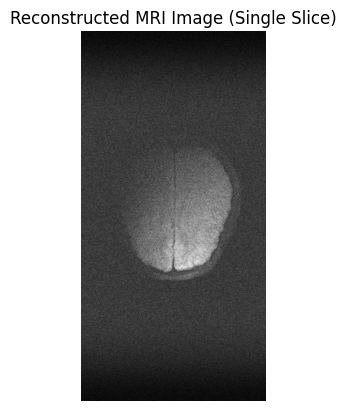

In [ ]:
# Test k-space-to-image pipeline
import h5py
import torch
import numpy as np
from fastmri import ifft2c, tensor_to_complex_np

with h5py.File("/content/drive/MyDrive/MRI/multicoil_test_full/MRI_001.h5", "r") as hf:
    kspace = hf["kspace"][:]
    print(f"K-space shape: {kspace.shape}")

kspace_complex = np.stack((np.real(kspace), np.imag(kspace)), axis=-1)
kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32)

image_tensor = ifft2c(kspace_tensor)
image_np = tensor_to_complex_np(image_tensor)



combined_image = np.sqrt(np.sum(np.abs(image_np) ** 2, axis=0))  # Combine along the coil axis


normalized_image = (combined_image - np.min(combined_image)) / (np.max(combined_image) - np.min(combined_image)) * 255.0

final_image = normalized_image.astype(np.uint8)


single_slice_image = final_image[0]  # Select the first coil or appropriate slice
print(f"Single slice shape: {single_slice_image.shape}")  # Should be (640, 320)

import matplotlib.pyplot as plt
plt.imshow(single_slice_image, cmap="gray")
plt.title("Reconstructed MRI Image (Single Slice)")
plt.axis("off")
plt.show()


Single slice shape: (640, 320)


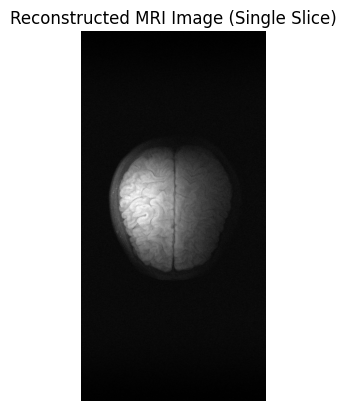

In [ ]:
# Display
single_slice_image = final_image[9]  # Select the first coil or appropriate slice
print(f"Single slice shape: {single_slice_image.shape}")  # Should be (640, 320)

import matplotlib.pyplot as plt
plt.imshow(single_slice_image, cmap="gray")
plt.title("Reconstructed MRI Image (Single Slice)")
plt.axis("off")
plt.show()

In [ ]:
file_path = "/content/drive/MyDrive/MRI/multicoil_test_full/file_brain_AXT2_200_2000304.h5"
with h5py.File(file_path, "r") as hf:
    kspace = hf["kspace"][:]
    print(kspace.shape)

(16, 16, 768, 396)


In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.8 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=8595b788e7dc1f302946f330b2cfabea44f6763e505104c6011ba0b9eb52da94
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


** Converting AXT2.h5 files into images in their folders **

In [ ]:
import os
import h5py
import numpy as np
import torch
from fastmri import tensor_to_complex_np, ifft2c
from tqdm import tqdm


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from PIL import Image

In [ ]:
# chessboard like images

def kspace_to_image_fastmri_gpu(kspace_data):
    """Converts k-space data to separate images for each coil using fastMRI with GPU acceleration."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)  # Shape: (num_coils, height, width, 2)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")

    image_tensor = ifft2c(kspace_tensor)  # Shape: (num_coils, height, width)

    magnitude_images = torch.abs(image_tensor)

    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)  # Per-coil min normalization
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)  # Per-coil max normalization
    magnitude_images *= 255.0  # Scale to 0-255

    normalized_images = magnitude_images.byte().cpu().numpy()  # Convert to uint8
    return normalized_images  # Shape: (num_coils, height, width)



t2_folder = "/content/drive/MyDrive/MRI"  # Path to your T2 .h5 files
output_folder = "/content/drive/MyDrive/MRI/sample_MRI"  # Path to save the images


os.makedirs(output_folder, exist_ok=True)

for file_name in tqdm(os.listdir(t2_folder), desc="Processing T2 .h5 files"):
    if file_name.endswith(".h5"):
        file_path = os.path.join(t2_folder, file_name)

        with h5py.File(file_path, "r") as hf:
            kspace = hf["kspace"][:]  # Shape: (num_slices, num_coils, height, width)
            num_slices = kspace.shape[0]
            num_coils = kspace.shape[1]

            mri_output_folder = os.path.join(output_folder, file_name.replace(".h5", ""))
            os.makedirs(mri_output_folder, exist_ok=True)

            for slice_idx in range(num_slices):
                slice_kspace = kspace[slice_idx]  # Shape: (num_coils, height, width)
                coil_images = kspace_to_image_fastmri_gpu(slice_kspace)  # Shape: (num_coils, height, width)

                for coil_idx in range(num_coils):
                    output_path = os.path.join(
                        mri_output_folder, f"slice_{slice_idx:03d}_coil_{coil_idx:02d}.png"
                    )
                    Image.fromarray(coil_images[coil_idx]).save(output_path)

print("All T2 .h5 files have been converted and saved.")

Processing T2 .h5 files: 100%|██████████| 9/9 [00:10<00:00,  1.15s/it]

All T2 .h5 files have been converted and saved.


In [ ]:
    # Add a complex dimension for k-space

def kspace_to_image_fastmri_gpu(kspace_data):
    """Converts k-space data to separate images for each coil using GPU acceleration."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)  # Shape: (num_coils, height, width, 2)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")

    image_tensor = ifft2c(kspace_tensor)  # Shape: (num_coils, height, width)

    magnitude_images = torch.abs(image_tensor)

    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)  # Per-coil min normalization
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)  # Per-coil max normalization
    magnitude_images *= 255.0  # Scale to 0-255

    normalized_images = magnitude_images.byte().cpu().numpy()  # Convert to uint8
    return normalized_images  # Shape: (num_coils, height, width)

from PIL import Image

def crop_or_resize_image(image, target_size=(320, 640)):
    """
    Crops or resizes an image to the target size, handling images with complex dimensions.

    Args:
        image (numpy.ndarray): Input image with or without a complex dimension.
        target_size (tuple): Desired output size (height, width).

    Returns:
        numpy.ndarray: Cropped and resized image.
    """
    if image.ndim == 3 and image.shape[-1] == 2:  
        image = np.abs(image[..., 0] + 1j * image[..., 1]) 

    if image.ndim != 2:
        raise ValueError(f"Unexpected image shape after handling complex dim: {image.shape}")

    current_height, current_width = image.shape
    target_height, target_width = target_size

    
    crop_top = max((current_height - target_height) // 2, 0)
    crop_bottom = crop_top + target_height
    crop_left = max((current_width - target_width) // 2, 0)
    crop_right = crop_left + target_width

    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]

    resized_image = Image.fromarray(cropped_image).resize(target_size, Image.Resampling.LANCZOS)
    return np.array(resized_image)



def process_h5_file(file_path, output_folder, target_size=(320, 640)):
    """Processes a single .h5 file and saves the images."""
    with h5py.File(file_path, "r") as hf:
        kspace = hf["kspace"][:]  
        num_slices = kspace.shape[0]
        num_coils = kspace.shape[1]

        
        mri_output_folder = os.path.join(output_folder, os.path.basename(file_path).replace(".h5", ""))
        os.makedirs(mri_output_folder, exist_ok=True)

        for slice_idx in range(num_slices):
            slice_kspace = kspace[slice_idx]  
            coil_images = kspace_to_image_fastmri_gpu(slice_kspace)  

            
            for coil_idx in range(num_coils):
                processed_image = crop_or_resize_image(coil_images[coil_idx], target_size)
                output_path = os.path.join(
                    mri_output_folder, f"slice_{slice_idx:03d}_coil_{coil_idx:02d}.jpeg"
                )
                Image.fromarray(processed_image).convert("L").save(output_path, "JPEG")

def process_all_h5_files(t2_folder, output_folder, target_size=(320, 640)):
    """Processes all .h5 files in the T2 folder."""
    os.makedirs(output_folder, exist_ok=True)

    for file_name in tqdm(os.listdir(t2_folder), desc="Processing T2 .h5 files"):
        if file_name.endswith(".h5"):
            file_path = os.path.join(t2_folder, file_name)
            process_h5_file(file_path, output_folder, target_size)

t2_folder = "/content/drive/MyDrive/MRI" 
output_folder = "/content/drive/MyDrive/MRI/sample_MRI"  


process_all_h5_files(t2_folder, output_folder, target_size=(320, 640))


Processing T2 .h5 files: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Visualizing and saving combined images for MRI: combined_images
Visualizing and saving combined images for MRI: file_brain_AXT2_202_2020073


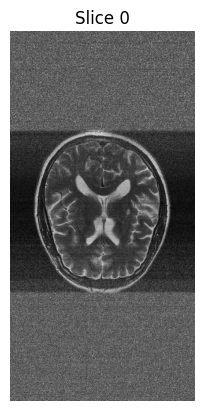

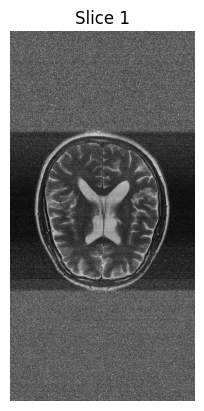

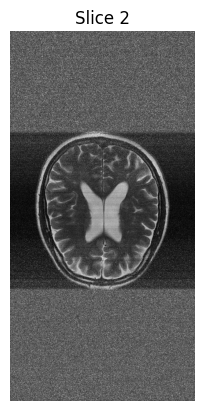

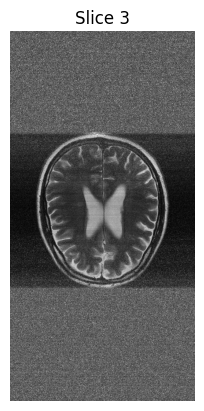

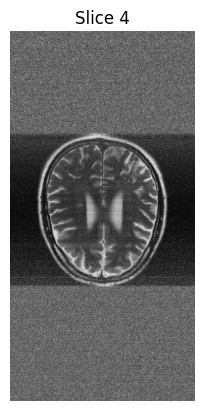

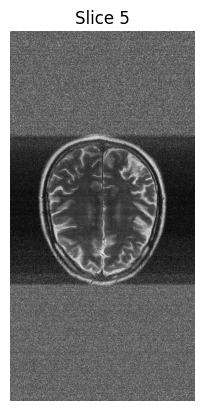

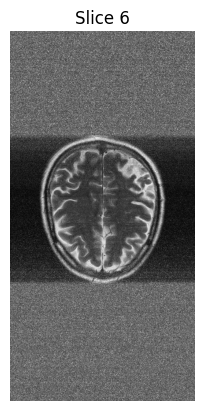

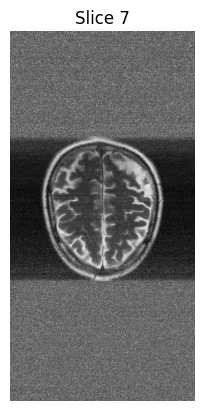

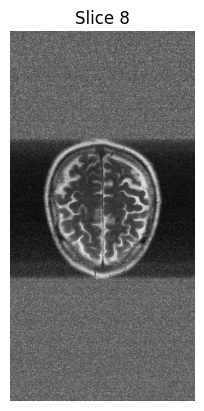

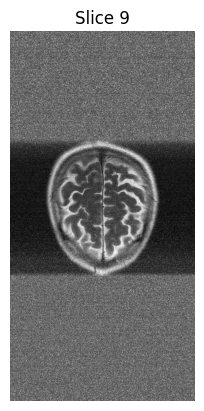

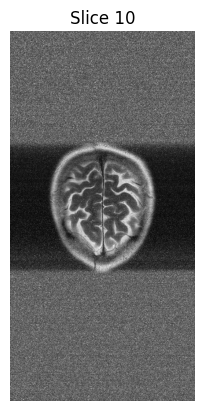

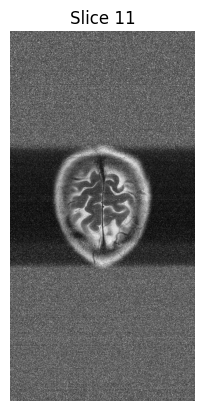

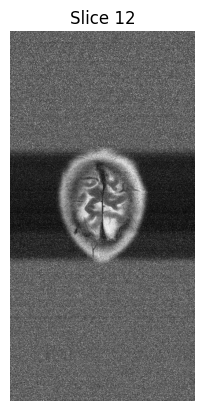

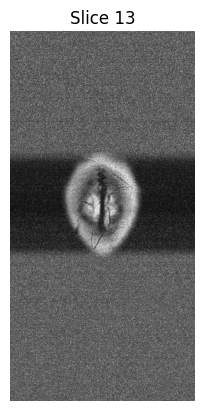

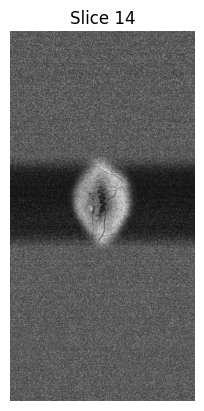

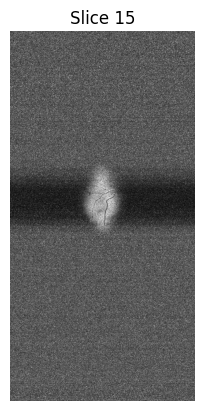

In [ ]:
    # Group files by slices
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def combine_coil_images(slice_folder):
    """
    Combines all coil images of each slice in a folder into a single image.

    Args:
        slice_folder (str): Path to the folder containing coil images for a single slice.

    Returns:
        list of np.ndarray: List of combined images for each slice.
    """
    combined_images = []

    slice_files = sorted(os.listdir(slice_folder))
    slices = {}
    for file_name in slice_files:
        if file_name.endswith(".png"):
            slice_idx = int(file_name.split("_")[1])
            if slice_idx not in slices:
                slices[slice_idx] = []
            slices[slice_idx].append(os.path.join(slice_folder, file_name))

   
    for slice_idx, coil_files in slices.items():
       
        coil_images = [np.array(Image.open(coil_file)) for coil_file in coil_files]
        coil_images = np.stack(coil_images, axis=0)  # Shape: (num_coils, height, width)

        
        combined_image = np.sqrt(np.sum(np.abs(coil_images.astype(np.float32)) ** 2, axis=0))

        
        if combined_image.ndim == 3 and combined_image.shape[-1] == 2:
            combined_image = np.abs(combined_image[..., 0] + 1j * combined_image[..., 1])

        
        combined_image -= combined_image.min()
        combined_image /= combined_image.max()
        combined_image *= 255.0
        combined_images.append(combined_image.astype(np.uint8))

    return combined_images

def visualize_combined_images(folder_path, output_folder):
    """
    Visualizes combined images for each slice in a folder and saves them.

    Args:
        folder_path (str): Path to the folder containing MRI sub-folders.
        output_folder (str): Path to save combined images.
    """
    
    os.makedirs(output_folder, exist_ok=True)

    
    for mri_folder in sorted(os.listdir(folder_path)):
        mri_folder_path = os.path.join(folder_path, mri_folder)
        if os.path.isdir(mri_folder_path):
            print(f"Visualizing and saving combined images for MRI: {mri_folder}")

            
            combined_images = combine_coil_images(mri_folder_path)

           
            for idx, combined_image in enumerate(combined_images):
                output_path = os.path.join(output_folder, f"{mri_folder}_slice_{idx:03d}.jpeg")
                Image.fromarray(combined_image).convert("L").save(output_path, "JPEG")

             
                plt.imshow(combined_image, cmap="gray")
                plt.title(f"Slice {idx}")
                plt.axis("off")
                plt.show()


processed_folder = "/content/drive/MyDrive/MRI/sample_MRI" 
output_combined_folder = "/content/drive/MyDrive/MRI/combined_images" 
visualize_combined_images(processed_folder, output_combined_folder)


In [ ]:
## Final Processing

In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 53.7 MB/s eta 0:00:00
  Created wheel for runstats: filename=runstats-2.0.0-py3-none-any.whl size=12358 sha256=a3a36f361415581872770f10026bda24fa285571176999bf594ee8db89cf6ecd
  Stored in directory: /root/.cache/pip/wheels/ab/f0/e7/de0153d4ef82770beff902f778ab825fa24c3534cb63564197
Successfully built runstats


In [ ]:
import os
import numpy as np
import h5py
import torch
from fastmri import ifft2c, tensor_to_complex_np
from tqdm import tqdm
from PIL import Image

In [ ]:
    # Retain central lines

def cartesian_sampling_mask(shape, retained_lines_fraction=0.8):
    """
    Generate a Cartesian sampling mask for k-space.

    Args:
        shape (tuple): Shape of the k-space (height, width).
        retained_lines_fraction (float): Fraction of lines to retain.

    Returns:
        numpy.ndarray: Sampling mask with the same shape as the k-space.
    """
    height, width = shape
    mask = np.zeros((height, width), dtype=np.float32)
    retained_lines = int(height * retained_lines_fraction)
    center = height // 2

    start = center - retained_lines // 2
    end = center + retained_lines // 2
    mask[start:end, :] = 1
    return mask

def apply_cartesian_sampling(kspace_data, mask):
    """
    Apply Cartesian sampling mask to k-space data.

    Args:
        kspace_data (numpy.ndarray): K-space data.
        mask (numpy.ndarray): Sampling mask.

    Returns:
        numpy.ndarray: Undersampled k-space data.
    """
    return kspace_data * mask

def kspace_to_image_with_cartesian_sampling(kspace_data, target_size=(320, 640), retained_lines_fraction=0.8):
    """
    Convert k-space data to undersampled images using Cartesian sampling and GPU.

    Args:
        kspace_data (numpy.ndarray): Input k-space data (num_coils, height, width).
        target_size (tuple): Target size for the output image (height, width).
        retained_lines_fraction (float): Fraction of lines to retain.

    Returns:
        list of numpy.ndarray: List of images for each coil and the combined image.
    """
    mask = cartesian_sampling_mask(kspace_data.shape[-2:], retained_lines_fraction)

    undersampled_kspace = apply_cartesian_sampling(kspace_data, mask)

    kspace_complex = np.stack((np.real(undersampled_kspace), np.imag(undersampled_kspace)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")

    image_tensor = ifft2c(kspace_tensor)

    magnitude_images = torch.abs(image_tensor)

    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)  # Per-coil min normalization
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)  # Per-coil max normalization
    magnitude_images *= 255.0
    magnitude_images = magnitude_images.byte().cpu().numpy()

    combined_image = np.sqrt(np.sum(np.abs(magnitude_images.astype(np.float32)) ** 2, axis=0))

    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    combined_image = combined_image.astype(np.uint8)

    resized_images = []
    for image in magnitude_images:
        image = np.abs(image)  # Ensure real values
        resized_image = Image.fromarray(image).resize(target_size, Image.Resampling.LANCZOS)
        resized_images.append(np.array(resized_image, dtype=np.uint8))

    combined_resized = Image.fromarray(combined_image).resize(target_size, Image.Resampling.LANCZOS)
    resized_combined_image = np.array(combined_resized, dtype=np.uint8)

    return resized_images, resized_combined_image


def process_h5_files_with_cartesian_sampling(input_folder, output_folder, target_size=(320, 640), retained_lines_fraction=0.8):
    """
    Process all .h5 files in the input folder and save undersampled images to the output folder.

    Args:
        input_folder (str): Path to the input folder containing .h5 files.
        output_folder (str): Path to save the processed images.
        target_size (tuple): Target size for the output images (height, width).
        retained_lines_fraction (float): Fraction of lines to retain in Cartesian sampling.
    """
    os.makedirs(output_folder, exist_ok=True)

    for file_name in tqdm(os.listdir(input_folder), desc="Processing .h5 files"):
        if file_name.endswith(".h5"):
            file_path = os.path.join(input_folder, file_name)

            with h5py.File(file_path, "r") as hf:
                kspace = hf["kspace"][:]  # Shape: (num_slices, num_coils, height, width)
                num_slices = kspace.shape[0]
                num_coils = kspace.shape[1]

                for slice_idx in range(num_slices):
                    slice_kspace = kspace[slice_idx]  # Shape: (num_coils, height, width)
                    undersampled_images, combined_image = kspace_to_image_with_cartesian_sampling(
                        slice_kspace, target_size=target_size, retained_lines_fraction=retained_lines_fraction
                    )

                    for coil_idx, image in enumerate(undersampled_images):
                        output_path = os.path.join(
                            output_folder, f"{file_name.replace('.h5', '')}_slice_{slice_idx:03d}_coil_{coil_idx:02d}.png"
                        )
                        Image.fromarray(image).convert("L").save(output_path)

                    combined_output_path = os.path.join(
                        output_folder, f"{file_name.replace('.h5', '')}_slice_{slice_idx:03d}_combined.png"
                    )
                    Image.fromarray(combined_image).convert("L").save(combined_output_path)


input_folder = "/content/drive/MyDrive/MRI"
output_folder = "/content/drive/MyDrive/MRI/masked"
process_h5_files_with_cartesian_sampling(input_folder, output_folder, target_size=(320, 640), retained_lines_fraction=0.8)

Processing .h5 files: 100%|██████████| 13/13 [00:11<00:00,  1.13it/s]


In [ ]:
    # Generate Cartesian sampling mask
def kspace_to_combined_image_with_cartesian_sampling(kspace_data, target_size=(320, 640), retained_lines_fraction=0.5):
    """
    Convert k-space data to a combined image using Cartesian sampling and GPU.

    Args:
        kspace_data (numpy.ndarray): Input k-space data (num_coils, height, width).
        target_size (tuple): Target size for the output image (height, width).
        retained_lines_fraction (float): Fraction of lines to retain.

    Returns:
        numpy.ndarray: Combined image after Cartesian sampling.
    """
    mask = cartesian_sampling_mask(kspace_data.shape[-2:], retained_lines_fraction)

   
    undersampled_kspace = apply_cartesian_sampling(kspace_data, mask)

 
    kspace_complex = np.stack((np.real(undersampled_kspace), np.imag(undersampled_kspace)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")

    image_tensor = ifft2c(kspace_tensor)

 
    magnitude_images = torch.abs(image_tensor)

  
    combined_image = np.sqrt(np.sum(np.abs(magnitude_images.cpu().numpy().astype(np.float32)) ** 2, axis=0))

    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    combined_image = combined_image.astype(np.uint8)

    combined_resized = Image.fromarray(combined_image).resize(target_size, Image.Resampling.LANCZOS)
    return np.array(combined_resized, dtype=np.uint8)

def process_h5_files_to_combined_images(input_folder, output_folder, target_size=(320, 640), retained_lines_fraction=0.5):
    """
    Process all .h5 files in the input folder and save only combined images to the output folder.

    Args:
        input_folder (str): Path to the input folder containing .h5 files.
        output_folder (str): Path to save the processed combined images.
        target_size (tuple): Target size for the output images (height, width).
        retained_lines_fraction (float): Fraction of lines to retain in Cartesian sampling.
    """
    os.makedirs(output_folder, exist_ok=True)

    for file_name in tqdm(os.listdir(input_folder), desc="Processing .h5 files"):
        if file_name.endswith(".h5"):
            file_path = os.path.join(input_folder, file_name)

            with h5py.File(file_path, "r") as hf:
                kspace = hf["kspace"][:]  # Shape: (num_slices, num_coils, height, width)
                num_slices = kspace.shape[0]

                for slice_idx in range(num_slices):
                    slice_kspace = kspace[slice_idx]  # Shape: (num_coils, height, width)
                    combined_image = kspace_to_combined_image_with_cartesian_sampling(
                        slice_kspace, target_size=target_size, retained_lines_fraction=retained_lines_fraction
                    )

                    combined_output_path = os.path.join(
                        output_folder, f"{file_name.replace('.h5', '')}_slice_{slice_idx:03d}_combined.png"
                    )
                    Image.fromarray(combined_image).convert("L").save(combined_output_path)

input_folder = "/content/drive/MyDrive/MRI"
output_folder = "/content/drive/MyDrive/MRI/masked"
process_h5_files_to_combined_images(input_folder, output_folder, target_size=(320, 640), retained_lines_fraction=0.5)


Processing .h5 files: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


In [ ]:
# comapring ground truth with masked images

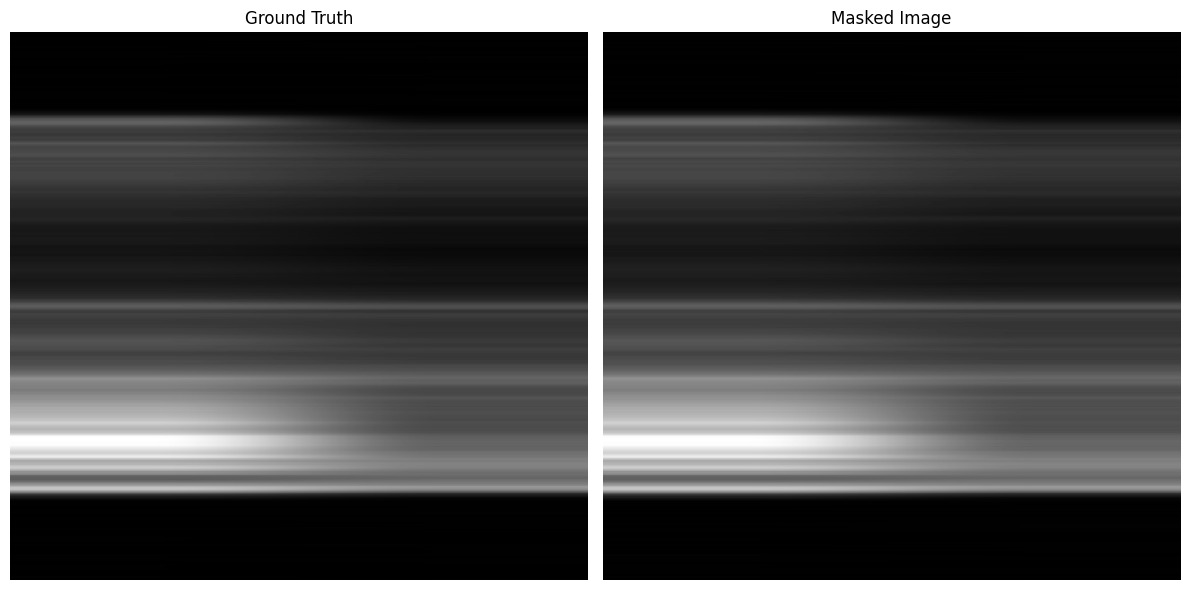

<Figure size 640x480 with 0 Axes>

In [ ]:
    # Generate Cartesian sampling mask
def create_ground_truth_image(kspace_data):
    """Convert full k-space to the ground truth image."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")
    image_tensor = ifft2c(kspace_tensor)
    combined_image = torch.sqrt(torch.sum(torch.abs(image_tensor) ** 2, dim=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.byte().cpu().numpy()


def create_masked_image(kspace_data, retained_lines_fraction):
    """Apply Cartesian sampling to k-space and create a masked image."""
    num_lines = kspace_data.shape[-2]
    num_retained_lines = int(num_lines * retained_lines_fraction)
    mask = np.zeros(kspace_data.shape[-2:], dtype=np.float32)
    center = num_lines // 2
    start = center - num_retained_lines // 2
    end = center + num_retained_lines // 2
    mask[start:end, :] = 1

    masked_kspace = kspace_data * mask

    
    kspace_complex = np.stack((np.real(masked_kspace), np.imag(masked_kspace)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")
    image_tensor = ifft2c(kspace_tensor)
    combined_image = torch.sqrt(torch.sum(torch.abs(image_tensor) ** 2, dim=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.byte().cpu().numpy()


def visualize_ground_truth_and_masked(h5_file_path, slice_idx, retained_lines_fraction):
    """Visualize the ground truth and masked images for a given slice."""
    with h5py.File(h5_file_path, "r") as hf:
        kspace = hf["kspace"][:] 
        slice_kspace = kspace[slice_idx] 

        
        combined_kspace = np.sum(slice_kspace, axis=0)

       
        ground_truth_image = create_ground_truth_image(combined_kspace)
        masked_image = create_masked_image(combined_kspace, retained_lines_fraction)

       
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(ground_truth_image, cmap="gray", aspect="auto")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(masked_image, cmap="gray", aspect="auto")
        plt.title("Masked Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


    plt.tight_layout()
    plt.show()


h5_file_path = "/content/drive/MyDrive/MRI/file_brain_AXT2_210_6001948.h5bb"  
slice_idx = 5  
retained_lines_fraction = 0.5 
visualize_ground_truth_and_masked(h5_file_path, slice_idx, retained_lines_fraction)


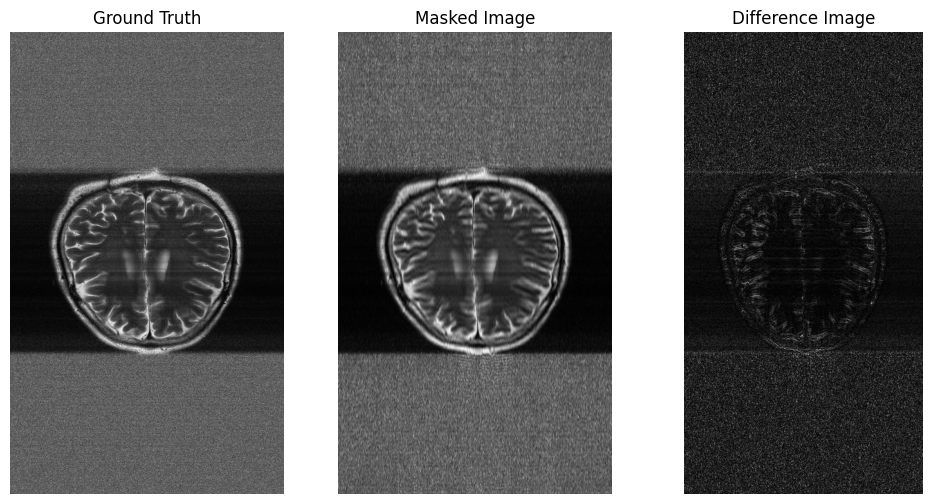

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define the k-space to image conversion functions
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import h5py

def kspace_to_image(kspace_data):
    """
    Convert k-space data to an image using inverse FFT.

    Args:
        kspace_data (numpy.ndarray): Input k-space data (num_coils, height, width).

    Returns:
        numpy.ndarray: Magnitude images for each coil.
    """
    
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")

    
    image_tensor = ifft2c(kspace_tensor)
    magnitude_images = torch.abs(image_tensor)

    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)
    magnitude_images *= 255.0
    return magnitude_images.byte().cpu().numpy()

def combine_images(images):
    """
    Combine images from multiple coils using Root Sum of Squares (RSS).

    Args:
        images (numpy.ndarray): Images for each coil (num_coils, height, width).

    Returns:
        numpy.ndarray: Combined image.
    """
    combined_image = np.sqrt(np.sum(images.astype(np.float32) ** 2, axis=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.astype(np.uint8)

def cartesian_sampling_mask(shape, retained_fraction):
    """
    Generate a Cartesian sampling mask.

    Args:
        shape (tuple): Shape of the k-space (height, width).
        retained_fraction (float): Fraction of lines to retain.

    Returns:
        numpy.ndarray: Cartesian sampling mask.
    """
    mask = np.zeros(shape, dtype=bool)
    center_lines = int(shape[0] * retained_fraction)
    start_line = shape[0] // 2 - center_lines // 2
    mask[start_line:start_line + center_lines, :] = True
    return mask

def apply_cartesian_sampling(kspace, mask):
    """
    Apply Cartesian sampling mask to k-space.

    Args:
        kspace (numpy.ndarray): K-space data (num_coils, height, width).
        mask (numpy.ndarray): Sampling mask (height, width).

    Returns:
        numpy.ndarray: Undersampled k-space.
    """
    return kspace * mask[None, :, :]


def display_ground_truth_and_masked(kspace_slice, retained_lines_fraction=0.3):
    """
    Displays ground truth and masked images side by side.

    Args:
        kspace_slice (numpy.ndarray): K-space data for a single slice (num_coils, height, width).
        retained_lines_fraction (float): Fraction of retained lines for Cartesian sampling.
    """
    
    ground_truth_image = kspace_to_image(kspace_slice)
    ground_truth_combined = combine_images(ground_truth_image)

    mask = cartesian_sampling_mask(kspace_slice.shape[-2:], retained_lines_fraction)

    undersampled_kspace = apply_cartesian_sampling(kspace_slice, mask)
    masked_image = kspace_to_image(undersampled_kspace)
    masked_combined = combine_images(masked_image)

    
    if ground_truth_combined.ndim == 3 and ground_truth_combined.shape[-1] == 2:
        ground_truth_combined = np.abs(ground_truth_combined[..., 0] + 1j * ground_truth_combined[..., 1])
    if masked_combined.ndim == 3 and masked_combined.shape[-1] == 2:
        masked_combined = np.abs(masked_combined[..., 0] + 1j * masked_combined[..., 1])

    difference_image = np.abs(ground_truth_combined - masked_combined)

   
    plt.figure(figsize=(12, 6))

   
    plt.subplot(1, 3, 1)
    plt.imshow(ground_truth_combined, cmap="gray", aspect="auto")
    plt.title("Ground Truth")
    plt.axis("off")

  
    plt.subplot(1, 3, 2)
    plt.imshow(masked_combined, cmap="gray", aspect="auto")
    plt.title("Masked Image")
    plt.axis("off")

    
    plt.subplot(1, 3, 3)
    plt.imshow(difference_image, cmap="gray")
    plt.title("Difference Image")
    plt.axis("off")
    plt.show()

    plt.tight_layout()
    plt.show()

file_path = "/content/drive/MyDrive/MRI/file_brain_AXT2_210_6001948.h5" 
slice_idx = 5  

with h5py.File(file_path, "r") as hf:
    kspace = hf["kspace"][:]  
    kspace_slice = kspace[slice_idx]  

display_ground_truth_and_masked(kspace_slice, retained_lines_fraction=0.2)


In [ ]:
!nvidia-smi

Wed Jan  1 20:19:36 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              31W /  70W |    277MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--